In [1]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
import json
import pandas as pd

from utils.config import Config
from utils.visualization import plot_overfitting, plot_test_metrics

/home/dom/Projects/trading-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check Metrics

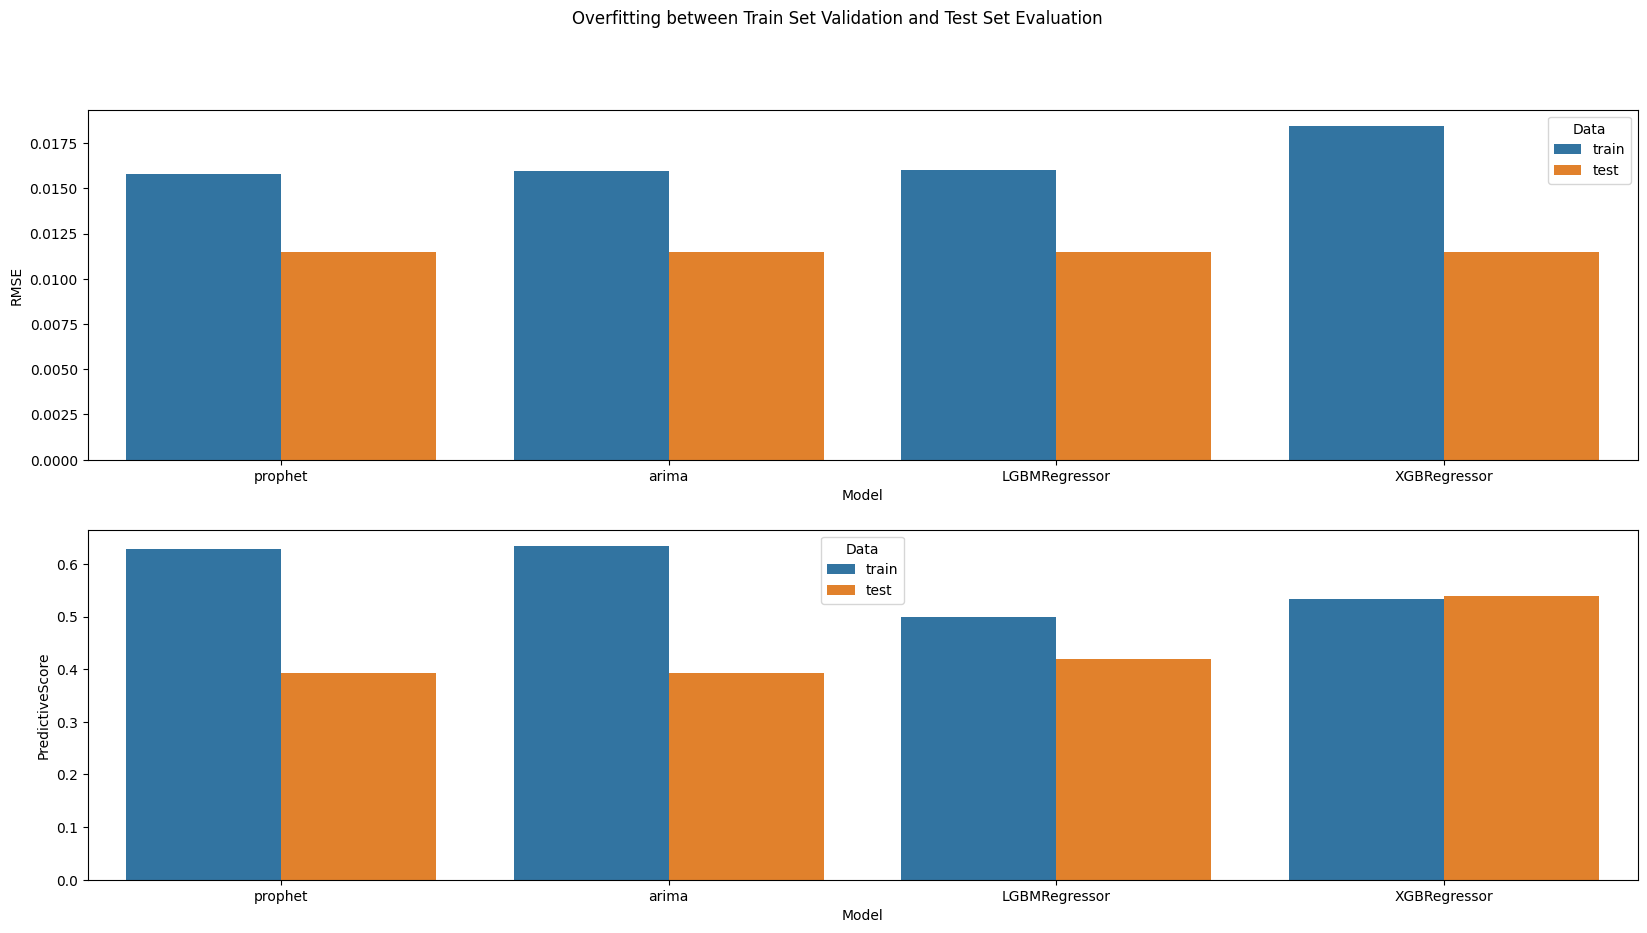

In [2]:
plot_overfitting()

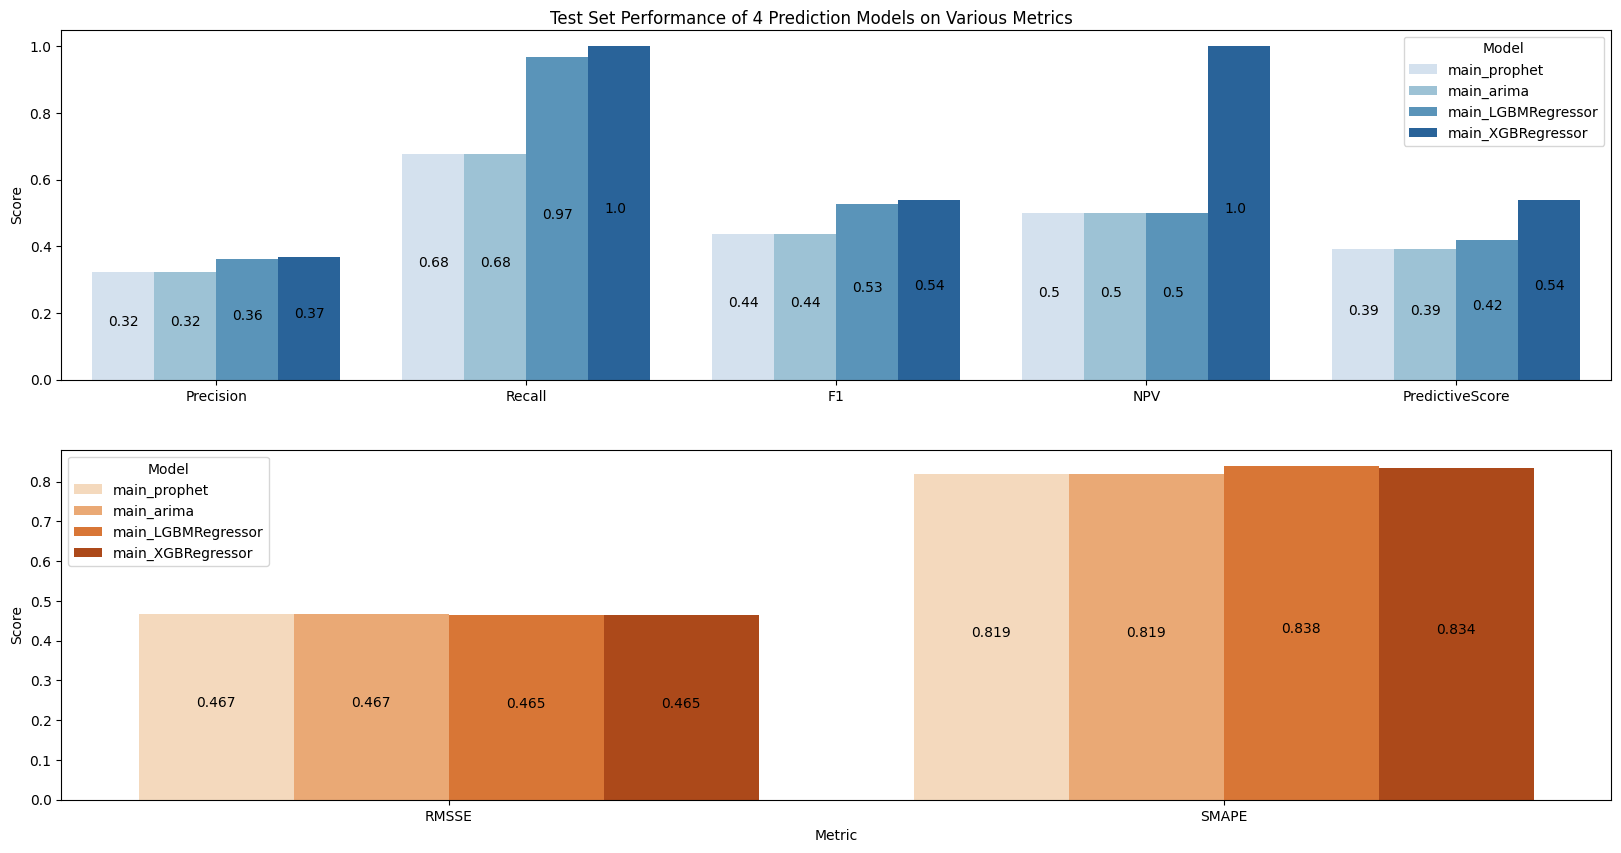

In [3]:
plot_test_metrics()

### Check Recommendation

In [4]:
rec = json.load(open("../results/recommendation.json", "r"))
for pt in ["short", "long"]:
    print(pt)
    for k, v in rec[pt].items():
        if k in ["risk", "reward"]:
            continue
        print(f"{k}: {v}")
    print()

short
Top Models: ['main_XGBRegressor', 'main_prophet', 'main_arima']
Median SMAPE: 0.8265
Median NPV: 0.5

long
Top Models: ['main_XGBRegressor', 'main_LGBMRegressor', 'main_prophet']
Median SMAPE: 0.8265
Median PPV: 0.34225



In [5]:
long = pd.DataFrame({k: v for k, v in rec["long"].items() if k in ["risk", "reward"]}).transpose()
short = pd.DataFrame({k: v for k, v in rec["short"].items() if k in ["risk", "reward"]}).transpose()
df = pd.concat([
    pd.concat({"long": long}, names=["PositionType"]),
    pd.concat({"short": short}, names=["PositionType"])
])
df

Top Stock Median Predicted Return Model Agreement  \
PositionType                                                                
long         risk    AT0000A21KS2                 1.00536             2/3   
             reward  AT0000741053                 1.00755             1/3   
short        risk    AT0000785555                 0.99412             2/3   
             reward  AT0000785555                 0.99412             2/3   

                    Market Trend MACD Crossover Market State  \
PositionType                                                   
long         risk        neutral              0   overbought   
             reward      neutral              0   overbought   
short        risk        neutral              0     oversold   
             reward      neutral              0     oversold   

                    Relative Strength Index Fast Stochastic Oscillator  \
PositionType                                                             
long         risk                        66                         91   
             reward                      68                        100   
short        risk                        29                          4   
             reward                      29                          4   

                    Bollinger Band Breakout  
PositionType                                 
long         risk                         0  
             reward                       1  
short        risk                         0  
             reward                       0

### Trade

In [13]:
# Select
position_type = "long"
optimize = "risk"

trade = df.loc[position_type].loc[optimize]
print(trade["Top Stock"])
trade["ISIN Description"] = Config().securities[trade["Top Stock"]]
trade["Position Type"] = position_type
trade["Optimize"] = optimize
trade["Top Models"] = rec[position_type]["Top Models"]
trade["Median SMAPE"] = rec[position_type]["Median SMAPE"]
trade["Median PPV/NPV"] = rec[position_type]["Median PPV"] if position_type == "long" else rec[position_type]["Median NPV"]

AT0000A21KS2


In [14]:
# Open
trade["WKN"] = ""
trade["WKN Description"] = ""
trade["Security Type"] = "turbo"
trade["Fundamentals"] = ""
trade["Git Tag"] = "20231102"
trade["Open Date"] = ""
trade["Open Price"] = 0
trade["Stop Limit"] = 0
trade["Shares"] = 0
trade

Top Stock                                                          AT0000A21KS2
Median Predicted Return                                                 1.00536
Model Agreement                                                             2/3
Market Trend                                                            neutral
MACD Crossover                                                                0
Market State                                                         overbought
Relative Strength Index                                                      66
Fast Stochastic Oscillator                                                   91
Bollinger Band Breakout                                                       0
ISIN Description                                     immofinanz-ag-AT0000A21KS2
Position Type                                                              long
Optimize                                                                   risk
Top Models                    [main_XGBR

In [8]:
# Close
trade["Close Price"] = 0
trade["Gross Profit"] = 0
trade["Fees"] = 0
trade["Net Profit"] = 0
trade["Reward"] = 0
trade

Top Stock                                                      AT0000785555
Median Predicted Return                                             0.99412
Model Agreement                                                         2/3
Market Trend                                                        neutral
MACD Crossover                                                            0
Market State                                                       oversold
Relative Strength Index                                                  29
Fast Stochastic Oscillator                                                4
Bollinger Band Breakout                                                   0
ISIN Description                           semperit-ag-holding-AT0000785555
Position Type                                                         short
Optimize                                                               risk
Top Models                    [main_XGBRegressor, main_prophet, main_arima]
Median SMAPE

In [9]:
# Persist
path = "../results/trades.csv"
trades = pd.read_csv(path, sep=";")
# pd.concat([trades, trade]).to_csv(path, sep=";", index=False)